# Drift Time - a brief look at

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

## Lettura dati e pulizia

In [2]:
# numero della run da cui leggere i dati
RUNNUMBER = 1251

In [3]:
# leggo il file di dati relativo alla run scelta
# NB: ho scaricato alcune run da CVeneto per comodità 
data = pd.read_csv(f'../DATA/RUN00{RUNNUMBER}_data.txt',sep=' ')

In [4]:
# ignoro possibili canali oltre il 128 (tengo il 128 perchè è lo scintillatore)
data = data[(data['TDC_CHANNEL']<=128)]
data.reset_index(inplace=True, drop=True)

In [5]:
# check 
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,2,0,73,40401361,983,6.0
1,2,1,6,40401361,982,14.0
2,2,0,13,40401361,981,28.0
3,2,1,7,40401361,984,30.0
4,2,0,10,40401361,983,8.0
...,...,...,...,...,...,...
121874893,2,0,57,694089689,1359,30.0
121874894,2,0,55,694089689,1363,11.0
121874895,2,0,56,694089689,1363,10.0
121874896,2,1,82,694089693,140,18.0


## Calcolo del Tempo di Deriva

In [6]:
# creo una nuova colonna dove converto i BX_COUNTER in TDC_MEAS 
# 1 BX_COUNTER corrisponde a 30 TDC_MEAS
data['TIME'] = data['BX_COUNTER']*30 + data['TDC_MEAS']

In [7]:
# prendo tutti gli eventi segnalati dallo scintillatore
scint = data[(data['TDC_CHANNEL']==128)]

In [8]:
# check
scint

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
60,2,1,128,40401674,3391,9.0,101739.0
287,2,1,128,40403216,931,16.0,27946.0
1425,2,1,128,40410943,402,3.0,12063.0
2461,2,1,128,40416125,321,9.0,9639.0
2662,2,1,128,40417081,414,2.0,12422.0
...,...,...,...,...,...,...,...
121868342,2,1,128,694052783,1541,6.0,46236.0
121869923,2,1,128,694062224,481,14.0,14444.0
121870880,2,1,128,694067404,1131,14.0,33944.0
121872139,2,1,128,694074152,2801,2.0,84032.0


In [9]:
# uso solo i primi n segnali dello scintillatore 
n=5000
# altrimenti ci mette una vita e mezza 
scint_small_dataset = scint.iloc[0:n]
scint_small_dataset.reset_index(inplace=True, drop=True)

# check
scint_small_dataset                          

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
0,2,1,128,40401674,3391,9.0,101739.0
1,2,1,128,40403216,931,16.0,27946.0
2,2,1,128,40410943,402,3.0,12063.0
3,2,1,128,40416125,321,9.0,9639.0
4,2,1,128,40417081,414,2.0,12422.0
...,...,...,...,...,...,...,...
4995,2,1,128,54911418,2516,2.0,75482.0
4996,2,1,128,54913855,2673,5.0,80195.0
4997,2,1,128,54921027,282,19.0,8479.0
4998,2,1,128,54922937,256,19.0,7699.0


### !!! Calcolo !!! da rivedere: ci mette troppo tempo e non torna la distribuzione

In [10]:
# lista per contenere i tempi di deriva 
drift_time = []

# per ogni segnale misurato dallo scintillatore
for i, scint_orb_cnt in enumerate(scint_small_dataset['ORBIT_CNT']):
    # chiamo 'event' il dataframe contentente tutti i dati con stesso ORBIT_CNT dello scintillatore i-esimo
    # escludendo i segnali dello scintillatore (TDC_CHANNEL 128)
    event = data[(data['ORBIT_CNT']==scint_orb_cnt) & (data['TDC_CHANNEL']!=128)]
    # calcolo la drift time come (tempo dati - tempo scintillatore i-esimo)
    event['DRIFT_TIME'] = event['TIME'] - scint_small_dataset['TIME'].iloc[i]
    # aggiungo alla lista le drift time dell'evento i-esimo 
    drift_time.append(event['DRIFT_TIME'])

# unisco i dataframe salvati nella lista in uno unico dataframe
drift_time = pd.concat(drift_time, ignore_index=True)

In [24]:
# check
print(drift_time)
print()

# stampa del valore massimo e del valore minimo:
# se sono esagerati c'è qualcosa che non va
print('Minimo: ' + format(drift_time.min(), '.0f'))
print('Massimo: ' + format(drift_time.max(), '.0f'))

0        -30832.0
1        -30839.0
2        -30655.0
3        -30706.0
4        -30812.0
           ...   
421837   -30544.0
421838   -30421.0
421839   -30532.0
421840   -30561.0
421841   -30399.0
Name: DRIFT_TIME, Length: 421842, dtype: float64

Minimo: -110009
Massimo: 96746


### Plot Distribuzione

In [12]:
def plotRange(distr, percentage = 10):
    '''dato un dataset in ingresso calcola il plot range opportuno per visualizzarne la distribuzione'''
    
    # prendo il minimo ed il massimo della lista
    distr_min = distr.min()
    distr_max = distr.max()
    
    # calcolo la larghezza della distribuzione
    width = np.abs(distr_max-distr_min)
    
    # imposto i limiti come massimo(minimo) della distribuzione sommando(sottraento) ad esso una certa percentuale della larghezza della distribuzione
    xmin = distr_min - (width*percentage/100)
    xmax = distr_max + (width*percentage/100)
    
    return xmin, xmax

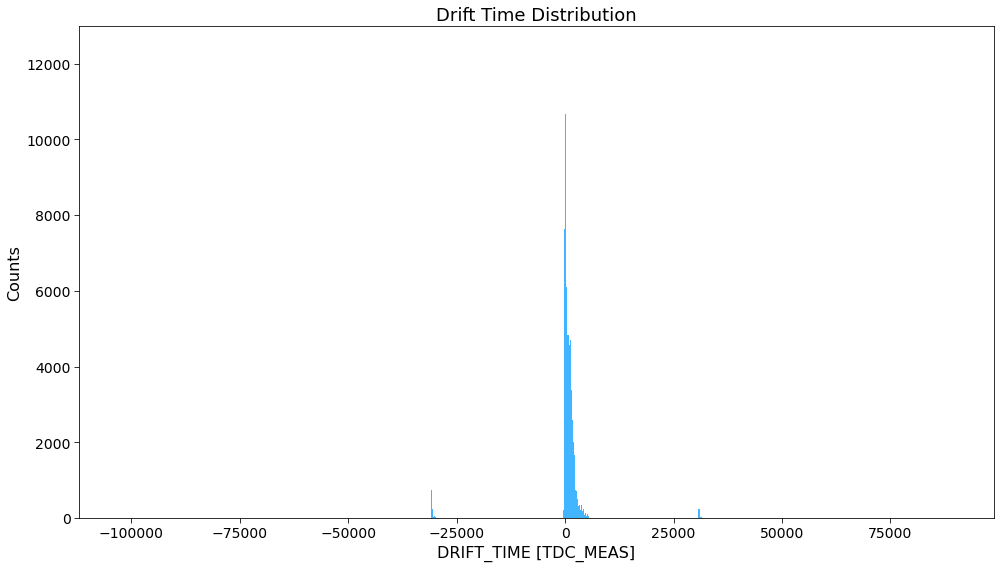

In [29]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

# istogramma del tempo di deriva
ax = sns.histplot(x=drift_time, # bins=500, 
                 stat='count', element='bars', fill=True, color='#009cff', edgecolor='white')


# gestione del plot range
ax.set_xlim(plotRange(drift_time,1))

# imposto titolo e label degli assi
ax.set_title('Drift Time Distribution', fontsize = 18)
ax.set_xlabel('DRIFT_TIME [TDC_MEAS]', fontsize = 16)
ax.set_ylabel('Counts', fontsize = 16)

# sistemo i ticks 
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)

fig.tight_layout()
plt.show()

#### Ci sono dei picchi molto piccoli (alcuni non sono nemmeno visibili dal grafico) e molto distanti oltre gli estremi della distribuzione centrale

#### Diminuisco il plot range in modo da inquadrare bene la distribuzione centrale

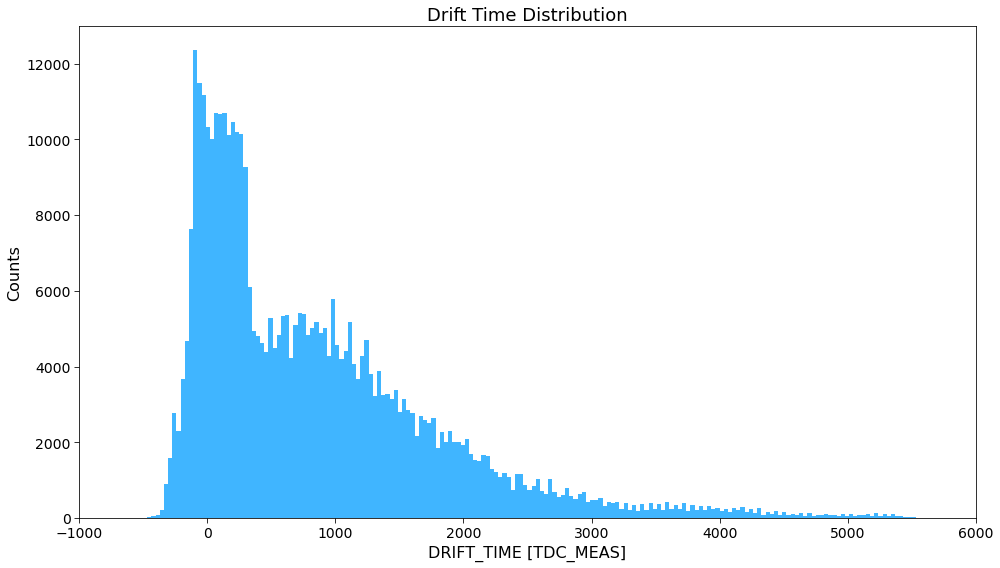

In [30]:
# creo figure&axes
fig, ax = plt.subplots(figsize=(14,8))

# istogramma del tempo di deriva
ax = sns.histplot(x=drift_time, # bins=500, 
                 stat='count', element='bars', fill=True, color='#009cff', edgecolor='white')


# gestione del plot range
ax.set_xlim(-1000, 6000) # impostato ad hoc manualmente

# imposto titolo e label degli assi
ax.set_title('Drift Time Distribution', fontsize = 18)
ax.set_xlabel('DRIFT_TIME [TDC_MEAS]', fontsize = 16)
ax.set_ylabel('Counts', fontsize = 16)

# sistemo i ticks 
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, direction = 'out', length = 5)

fig.tight_layout()
plt.show()